In [1]:
from IPython.display import display, Math, Latex

# Libraries you might need
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns

In [2]:
# You can use this function for plotting raster plots (spikes), or you can use your own defined function
def raster(event_times_list, color='k', t_min= 0., t_max=10., ax=None):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    https://scimusing.wordpress.com/2013/05/06/making-raster-plots-in-python-with-matplotlib/
    """
    if ax is None:
        ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        ax.vlines(trial, ith + .5, ith + 1.5, color=color)
    ax.set_ylim(.5, len(event_times_list) + .5)
    ax.set_yticks([])
    ax.set_ylabel('Spike train')
    ax.set_xlim((t_min, t_max))
    # ax.set_xlabel('Time [s]')
    return ax

def plot_raster_and_rate(spike_trains, rate_estimate, bin_centers, t_min, t_max, analytic_rate):
    # plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.8, 5), sharex=True)

    # Raster plot
    raster(spike_trains, t_min=t_min, t_max=t_max, ax=ax1)

    # Rate plot
    ax2.plot(bin_centers, rate_estimate, label="Numeric")
    ax2.plot(bin_centers, analytic_rate, label="Analytical")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Rate [Hz]")
    ax2.legend()

    plt.show()

### Homework 2

__1. Generation of inhomogeneous Poisson process__. Consider an inhomogeneous Poisson process with instanteneous firing rate $\lambda: \mathbb{R} \to \mathbb{R}^+$ such that $\lambda(t) = \lambda_{max} (t-1)^2$, where $t$ is measured in seconds, $\lambda$ in Herz [Hz].

In exercise (a) - (d), generate $N = 100$ spike trains for $\lambda_{max} = 100$ Hz. Plot the raster plot, the numeric approximation of the rate and for comparison the analytic rate given in the exercise.
A numeric approximation of the rate $\tilde\lambda$ can be computed by binning the data into 100 bins on the interval $[t_{\text{min}}, t_{\text{max}}]$ for each spike train (bin size $\Delta t = \frac{t_{\text{max}}-t_{\text{min}}}2$) and computing the number of spikes in all spike trains within the bin, devided by $N$ and the bin size: $\tilde\lambda = \frac{\#spikes}{N \cdot \Delta t}$.

*Hint: Compute the analytical integral of the rate function. Write a function both for the rate function and its integral.*

In [3]:
def rate(t, rate_max):
    return rate_max*np.pow(t-1,2)

def indefinite_integral(t, rate_max):
    return rate_max*np.pow(t-1,3)/3.

def rate_integral(t_min, t_max, rate_max):
    return indefinite_integral(t_max, rate_max) - indefinite_integral(t_min, rate_max)

rate_max = 100
n_trials = 100
t_min = 0
t_max = 2
bins_count = np.linspace(t_min, t_max, 101)
bin_size = bins_count[1] - bins_count[0]

__a) Temporal distribution method:__ As in the lecture: first find number of spikes $k$ by drawing from Poisson distribution with parameter $\mu = \int_{t_{\text{min}}}^{t_{\text{max}}} \lambda(t) dt $, and then draw spike times using a density function $\lambda(t)/\mu$. _(2 points)_

*Hint: Choose an appropriate method for drawing from an arbitrary probability density, e.g., rejection sampling.*

In [4]:
# Function for computing numerical rate from given spike trains
def compute_rate_estimate(spike_trains, bins, n_trials):
    all_spikes = np.concatenate(spike_trains)
    bin_size = bins[1] - bins[0]
    counts, _ = np.histogram(all_spikes, bins=bins)
    return counts / (n_trials * bin_size)

In [5]:
# compute

def temporal_distribution_method(t_min, t_max, rate_max, n_trials):
    mu = rate_integral(t_min, t_max, rate_max)
    spike_trains = []

    # Rejection sampling for each trial
    for _ in range(n_trials):
        k = np.random.poisson(mu)  # total number of spikes for this trial
        spikes = []
        while len(spikes) < k:
            t_candidate = np.random.uniform(t_min, t_max) # uniform proposal distribution
            acceptance_prob = rate(t_candidate, rate_max) / rate_max
            if np.random.rand() < acceptance_prob: # rejection sampling
                spikes.append(t_candidate)
        spike_trains.append(np.array(spikes))
    return spike_trains

spike_trains = temporal_distribution_method(t_min, t_max, rate_max, n_trials)
rate_estimate = compute_rate_estimate(spike_trains, bins_count, n_trials)
bin_centers = (bins_count[:-1] + bins_count[1:]) / 2
analytic_rate = rate(bin_centers, rate_max)

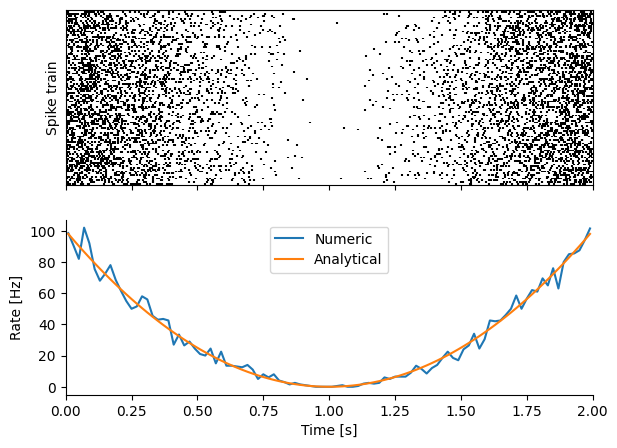

In [6]:
plot_raster_and_rate(spike_trains, rate_estimate, bin_centers, t_min, t_max, analytic_rate)

__b) Bernoulli method:__ Discretize time into $m$ bins. For each bin $j = 1, \ldots, m$ draw a sample $k_i$ from a Poisson spike count distribution in that bin ( Poisson distribution with the parameter equal to integral of the $\lambda(t)$ over the bin). Generate a single spike in each bin with $k_i > 0$ drawing its time-stamp from uniform distribution within this bin. Generate rasters and estimated rate for $m = 10, \: 100, \: 1000, \: 10000.$ _(2 points)_

*Note: The bin count for computing a numerical approximation of the rate is still the same as above.*

In [7]:
# compute

def bernoulli_method(rate_max, t_min, t_max, m, n_trials):
    bin_edges = np.linspace(t_min, t_max, m + 1)
    spike_trains = []

    for _ in range(n_trials):
        spikes = []
        for i in range(m):
            t0, t1 = bin_edges[i], bin_edges[i+1]
            mu_bin = rate_integral(t0, t1, rate_max)
            k = np.random.poisson(mu_bin)
            if k > 0:
                spikes_in_bin = np.random.uniform(t0, t1, size=1) # Only one spike per bin 
                spikes.extend(spikes_in_bin)
        spike_trains.append(np.array(spikes))

    return spike_trains

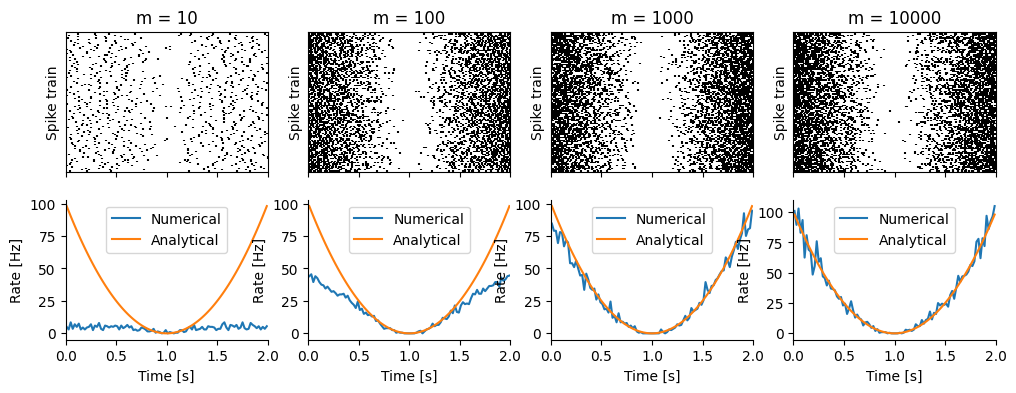

In [8]:
# plot

m_values = [10, 100, 1000, 10000]
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex='col')

for i, m in enumerate(m_values):
    spike_trains = bernoulli_method(rate_max, t_min, t_max, m, n_trials)
    rate_estimate = compute_rate_estimate(spike_trains, bins_count, n_trials)

    # Raster
    ax_raster = axes[0, i]
    raster(spike_trains, t_min=t_min, t_max=t_max, ax=ax_raster)
    ax_raster.set_title(f'm = {m}')
    ax_raster.set_ylabel("Spike train")

    # Rate plot
    ax_rate = axes[1, i]
    ax_rate.plot(bin_centers, rate_estimate, label='Numerical')
    ax_rate.plot(bin_centers, analytic_rate, label='Analytical')
    ax_rate.set_xlabel("Time [s]")
    ax_rate.set_ylabel("Rate [Hz]")
    ax_rate.spines['top'].set_visible(False)
    ax_rate.spines['right'].set_visible(False)
    ax_rate.legend()

__c) Thinning method:__ First generate a spike train from a Poisson process of rate $\lambda_{max}$ and then iterate through all spikes $l = 1, \ldots, k$ and randomly delete them with probability $1 - \lambda(t^\star_l) /\lambda_{max}$, where $t^\star_l$ is a time point of the $l$-th spike (before thinning). _(2 points)_

In [9]:
# compute
def thinning_method(rate_max, t_min, t_max, n_trials):
    tau = (t_max - t_min) / rate_max
    spike_trains = []
    for _ in range(n_trials):
        isi = np.random.exponential(tau, size = int((t_max - t_min)/tau)*2)
        proposed_spike_times = t_min + np.cumsum(isi)
        proposed_spike_times = proposed_spike_times[proposed_spike_times <= t_max]

        spike_times = []
        for t in proposed_spike_times:
            if np.random.rand() > 1 - (rate(t, rate_max) / rate_max):
                spike_times.append(t)
                
        spike_trains.append(spike_times)
        
    return spike_trains
            
spike_trains = thinning_method(rate_max, t_min, t_max, n_trials)
rate_estimate = compute_rate_estimate(spike_trains, bins_count, n_trials)

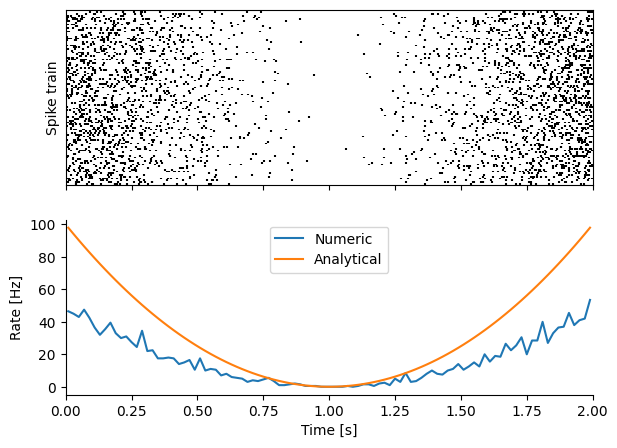

In [10]:
# plot
plot_raster_and_rate(spike_trains, rate_estimate, bin_centers, t_min, t_max, analytic_rate)

__d) Renewal and time rescaling method:__ Compute $\mu(t) = \int_{t_{min}}^t \lambda(s) ds$. Generate a spike train for a homogeneous Poisson process with rate $1$ on an interval $[0,\mu(t_{max})]$ (using inter-spike interval distribution as in the previous homework). Resulting spike times we call $s_l^\star$. We can then find corresponding pre-images $t_l^\star = \mu^{-1}(s_l^\star) \in [t_{min},t_{max}].$ _(2 points)_

Hint: Options for inverting functions:
- Invert $\mu(t)$ analytically and write a function. Of course, you can use any tools that you want. Remember to write your solution concisely including necessary intermediate steps.*
- You can also use "sympy" library to create symbolic equations and then find the inverse function using those symbolic equations _(2 points)_
- To find the inverse of a polynomial function at a specific value you can use function np.roots (https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html ). You will need a real root within the interval $[t_{min},t_{max}]$.

**Answer:**

We compute the analytical solution for $\mu(t)$ ($\because t_{\text{min}} = 0$):
$$
\begin{align*}
\mu(t) &= \int_0^t \lambda(u) \, du \\ &= \int_0^t \lambda_{\text{max}} (u - 1)^2 \, du \\
&= \lambda_{\text{max}} \int_0^t (u - 1)^2 \, du \\ &= \lambda_{\text{max}} \cdot \left[ \frac{(t - 1)^3}{3} + \frac{1}{3} \right] \\
\Rightarrow \mu(t) &= \frac{\lambda_{\text{max}}}{3} \left( (t - 1)^3 + 1 \right)
\end{align*}
$$

Thus, we can now compute its inverse. Let $ s = \mu(t) $:
$$
s = \frac{\lambda_{\text{max}}}{3} \left( (t - 1)^3 + 1 \right) \\

\Rightarrow \frac{3s}{\lambda_{\text{max}}} = (t - 1)^3 + 1 \\
\Rightarrow (t - 1)^3 = \frac{3s}{\lambda_{\text{max}}} - 1 \\
\Rightarrow t - 1 = \left( \frac{3s}{\lambda_{\text{max}}} - 1 \right)^{1/3} \\
\Rightarrow \boxed{t = \mu^{-1}(s) = 1 + \left( \frac{3s}{\lambda_{\text{max}}} - 1 \right)^{1/3}}
$$

In [11]:
# compute

def renewal_and_time_rescaling_method(rate_max, t_min, t_max, n_trials):
    mu = rate_integral(t_min, t_max, rate_max)
    get_pre_image = lambda s: 1 + np.cbrt(((3*s)/rate_max) - 1)

    spike_trains = []
    for _ in range(n_trials):
        isi_homogenous = np.random.exponential(1, size = int(mu) * 2) 
        s_star = np.cumsum(isi_homogenous)
        t_star = get_pre_image(s_star)
        t_star = t_star[(t_star >= t_min) & (t_star <= t_max)]
        spike_trains.append(t_star)
    
    return spike_trains

spike_trains = renewal_and_time_rescaling_method(rate_max, t_min, t_max, n_trials)        
rate_estimate = compute_rate_estimate(spike_trains, bins_count, n_trials)

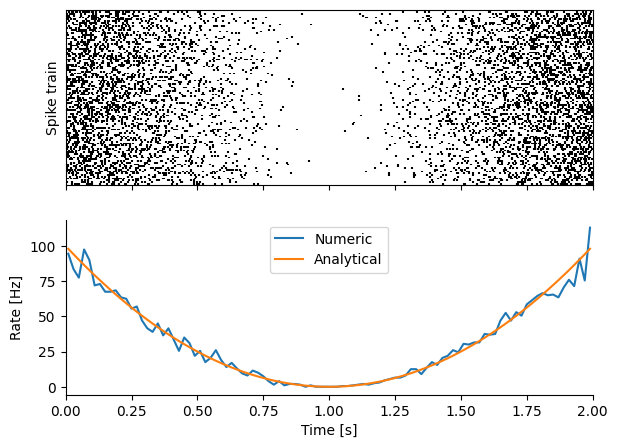

In [12]:
# plot
plot_raster_and_rate(spike_trains, rate_estimate, bin_centers, t_min, t_max, analytic_rate)

__2. Variance of the firing rate a)__. Determine the variance of the firing rate (across the bins) using $b = 10, \: 50, \:100$ bins from spike trains generated by method 1.a) using the law of total variance  _(2 points)_

**Answer:**

Formulas I need...

$$
\text{Var}(N_i) = (\Delta t)^2 \text{Var}(\lambda_i) + \mathbb{E}(N_i) \quad (\because \mathbb{E}(\lambda_i) = \frac{\mathbb{E}(N_i)}{\Delta t})
$$

$$
\text{Var}(\lambda_i) = \frac{\text{Var}(N_i) - \mathbb{E}(N_i)}{(\Delta t)^2}
$$

where $N_i$ and $\lambda_i$ is spike counts and firing rates respectively in the $i^{\text{th}}$ bin.


In [16]:
spike_trains = temporal_distribution_method(t_min, t_max, rate_max, n_trials)

def compute_variance(spike_trains, n_bins, t_min, t_max, n_trials):
    bin_edges = np.linspace(t_min, t_max, n_bins + 1)
    bin_size = (t_max - t_min) / n_bins
    spike_counts = np.zeros((n_trials, n_bins))  # Per trial, per bin
    
    # Count spikes per trial per bin
    for i, spikes in enumerate(spike_trains):
        counts, _ = np.histogram(spikes, bins=bin_edges)
        spike_counts[i, :] = counts
    
    # Total mean spike count per trial (sum across bins)
    total_mean_spike_counts = np.sum(spike_counts, axis=1).mean()  # Average total spikes per trial
    
    # Variance of spike counts across all trials and bins
    total_var_spike_counts = np.var(spike_counts.flatten(), ddof=1)
    
    # Estimate Var(lambda_i) using law of total variance

    mean_n_i = total_mean_spike_counts / n_bins
    var_lambda = (total_var_spike_counts - mean_n_i) / (bin_size ** 2)
    
    return total_mean_spike_counts, total_var_spike_counts, var_lambda

# Compute for different bin sizes
bin_sizes = [10, 50, 100]
for n_bins in bin_sizes:
    mean_counts, var_counts, var_lambda = compute_variance(spike_trains, n_bins, t_min, t_max, n_trials)
    print(f"n_bin={n_bins}")
    print(f"mean spike counts = {mean_counts}")
    print(f"var of spike counts = {var_counts}")
    print(f"var of firing rate = {var_lambda}")
    print("--------------------")

n_bin=10
mean spike counts = 67.05
var of spike counts = 41.493468468468464
var of firing rate = 869.7117117117115
--------------------
n_bin=50
mean spike counts = 67.05
var of spike counts = 2.820883176635327
var of firing rate = 924.9269853970794
--------------------
n_bin=100
mean spike counts = 67.05
var of spike counts = 1.0222319731973197
var of firing rate = 879.3299329932993
--------------------


__2. Variance of the firing rate b)__. Compare results from 2.a) with analytical variance of the rate. To compute the analytical variance use the true formula for the time-dependent rate $\lambda(t) = \lambda_{max} (t-1)^2$ and treat it as a random variable for the time $t$ uniformly distributed in $[t_{\text{min}},t_{\text{max}}]$. \\
_(2 points)_

The analytical variance of the firing rate $\lambda(t) = \lambda_{\text{max}} (t-1)^2$ is computed as follows, with $t \sim \text{Uniform}[0, 2]$ and probability density $p(t) = \frac{1}{2}$:

$$
\begin{equation*}
\begin{split}
Var(\lambda)
&= E[\lambda(t)^2] - [E[\lambda(t)]]^2 \\
&= \int_0^2 \lambda(t)^2 \cdot \frac{1}{2}dt - \left( \int_0^2 \lambda(t) \cdot \frac{1}{2} dt \right)^2 \\
&= \int_0^2 [\lambda_{\text{max}} (t-1)^2]^2 \cdot \frac{1}{2}dt - \left( \int_0^2 \lambda_{\text{max}} (t-1)^2 \cdot \frac{1}{2}dt \right)^2 \\
&= \frac{\lambda_{\text{max}}^2}{2} \int_0^2 (t-1)^4dt - \left( \frac{\lambda_{\text{max}}}{2} \int_0^2 (t-1)^2dt \right)^2 \\
&= \frac{\lambda_{\text{max}}^2}{2}\left[ \frac{(t-1)^5}{5} \right]_0^2  - \left( \frac{\lambda_{\text{max}}}{2} \left[ \frac{(t-1)^3}{3} \right]_0^2 \right)^2 \\
&= \frac{\lambda_{\text{max}}^2}{2} \cdot \frac{2}{5}  - \left( \frac{\lambda_{\text{max}}}{2} \cdot \frac{2}{3}\right)^2 \\
&= \frac{\lambda_{\text{max}}^2}{5} - \left( \frac{\lambda_{\text{max}}}{3} \right)^2 \\ 
&= \lambda_{\text{max}}^2 \left( \frac{1}{5} - \frac{1}{9} \right) \\
&= \lambda_{\text{max}}^2 \frac4{45}\\
&= 888.89
\end{split}
\end{equation*}
$$